## Import Dependencies

In [6]:
# import dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense


# sklearn features
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Import Data
Read in the csv containing the merged data from the weather API and Nest data.

In [31]:
data = pd.read_csv('../merged_data.csv')

## Clean the Data
Remove unnecessary columns with lots of missing values and check for ways to fix missing values (set to zero, median, mean etc.

In [32]:
# update NA values to zero for certain columns
data['precipAccumulation'] = data['precipAccumulation'].fillna(0)  # if precipitation accumulation is NAN assume 0
data['precipIntensity'] = data['precipIntensity'].fillna(0)  # if precipitation intensity is NAN assume 0
data['nearestStormBearing'] = data['nearestStormBearing'].fillna(0)

# drop precipType since it is redundant to icon or summary column
data.drop(['precipType'], axis = 1, inplace = True)
data.drop(['precipIntensityError'], axis = 1, inplace = True)
#data['precipType'] = data['precipType'].fillna('None')  # if precipitation intensity is NAN assume 0

## Correlation (Feature Engineering)

In [33]:
corr = data.corr()

corr['avg(temp)'].sort_values(ascending=False)
items = corr['avg(temp)'].sort_values(ascending=False)

In [34]:
items = items[abs(items) > .03]
items

avg(temp)               1.000000
max(pir)                0.115581
pressure                0.099506
min(als)                0.086489
avg(humidity)           0.060134
max(tp2)                0.054070
precipIntensity         0.053627
precipProbability       0.050140
max(als)                0.048026
max(tp1)                0.044541
max(tp3)                0.038411
windGust                0.032982
min(tp1)               -0.038771
visibility             -0.040281
nearestStormBearing    -0.045837
nearestStormDistance   -0.045873
humidity               -0.048433
min(tp2)               -0.061523
Name: avg(temp), dtype: float64

In [35]:
filtered = data.loc[: , items.index]
filtered.shape

(2698, 18)

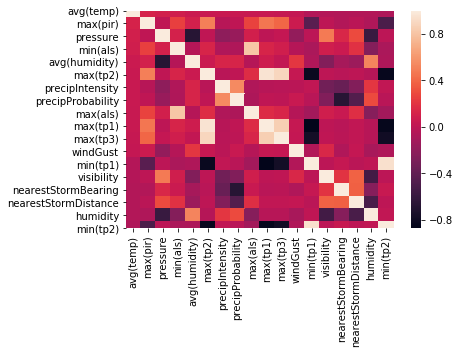

In [36]:
corr = filtered.corr()
sns.heatmap(corr)

## Convert Categorical Data to Numerical
In order to properly train a model we want to convert all of our dataframe columns that hold categorical data (ex. rainy, cloudy etc) into numerical data. 

There are several techniques to do so. The one I will be using is one hot encoding. This technique makes sure each different categorical value is weighted the same which the technique label encoding does not do.

One hot encoding adds additional feature columns to the dataset.

In [37]:
# summary column one hot encoding
summary_encode = pd.get_dummies(data.summary, prefix='summary')
# icon column one hot encoding
#icon_encode = pd.get_dummies(data.icon, prefix='icon')

In [38]:
# concat the one hot encoded columns onto our data and drop the original column
data = pd.concat([data, summary_encode], axis=1)
#data = pd.concat([data, icon_encode], axis=1)
data.drop(['summary'], axis = 1, inplace=True)
data.drop(['icon'], axis = 1, inplace=True)

## Data Exploration
Let's take a quick glance at the properties of our dataset in more detail.

In [39]:
# let's replace all our empty string cells with NaN and then drop them
data.replace('', np.nan, inplace=True)
data = data.dropna(axis = 0)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nearestStormDistance,2522.0,65.488898,50.036338,0.000,14.0000,64.000,112.0000,248.0000
nearestStormBearing,2522.0,149.210547,73.014344,0.000,132.0000,168.000,180.0000,357.0000
precipIntensity,2522.0,0.030123,0.145888,0.000,0.0000,0.000,0.0000,3.1955
precipProbability,2522.0,0.105226,0.294530,0.000,0.0000,0.000,0.0000,1.0000
temperature,2522.0,-2.856376,4.876273,-16.140,-6.0750,-2.430,0.7700,8.4800
apparentTemperature,2522.0,-7.061463,6.062284,-22.910,-11.0800,-7.080,-2.5300,5.9800
dewPoint,2522.0,-5.738382,6.364397,-21.540,-10.1600,-5.365,-0.5300,8.0800
humidity,2522.0,0.810599,0.123132,0.430,0.7200,0.810,0.9200,1.0000
pressure,2522.0,1014.602379,9.389654,992.200,1008.7000,1013.300,1021.1000,1035.8000
windSpeed,2522.0,12.668692,5.551586,2.410,7.9800,12.430,16.4700,26.8500


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522 entries, 0 to 2697
Data columns (total 42 columns):
time                         2522 non-null object
nearestStormDistance         2522 non-null int64
nearestStormBearing          2522 non-null float64
precipIntensity              2522 non-null float64
precipProbability            2522 non-null float64
temperature                  2522 non-null float64
apparentTemperature          2522 non-null float64
dewPoint                     2522 non-null float64
humidity                     2522 non-null float64
pressure                     2522 non-null float64
windSpeed                    2522 non-null float64
windGust                     2522 non-null float64
windBearing                  2522 non-null int64
cloudCover                   2522 non-null float64
uvIndex                      2522 non-null int64
visibility                   2522 non-null float64
ozone                        2522 non-null float64
precipAccumulation           2522

## Splitting the Data
Will split the data into 80% training data and 20% testing data. The validation set is 20% of the training data chosen randomly

In [41]:
data.drop(['time'], axis = 1, inplace = True)
# drop columns based on correlation values
data.drop(['temperature'], axis = 1, inplace = True)
data.drop(['apparentTemperature'], axis = 1, inplace = True)
data.drop(['windBearing'], axis = 1, inplace = True)
data.drop(['dewPoint'], axis = 1, inplace = True)
data.drop(['windSpeed'], axis = 1, inplace = True)
data.drop(['cloudCover'], axis = 1, inplace = True)
data.drop(['uvIndex'], axis = 1, inplace = True)
data.drop(['ozone'], axis = 1, inplace = True)
data.drop(['precipAccumulation'], axis = 1, inplace = True)
data.drop(['min(tp0)'], axis = 1, inplace = True)
data.drop(['max(tp0)'], axis = 1, inplace = True)
data.drop(['min(tp3)'], axis = 1, inplace = True)


# was getting strange NAN values within these two columns (not sure why, need to look into it)
data.drop(['summary_Rain'], axis = 1, inplace = True)
data.drop(['summary_Light Snow'], axis = 1, inplace = True)


column_indices = {name: i for i, name in enumerate(data.columns)}

size = len(data)
train_df = data[0:int(size * 0.8)]
test_df = data[int(size * 0.8):]

num_features = data.shape[1]

## Normalizing the Data

In [42]:
#drop target attribute before normalizing
train_target = train_df['avg(temp)']
test_target = test_df['avg(temp)']
train_df.drop(['avg(temp)'], axis = 1, inplace = True)
test_df.drop(['avg(temp)'], axis = 1, inplace = True)
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
# add target back to df
train_df['avg(temp)'] = train_target
test_df['avg(temp)'] = test_target

r2List = []
maeList = []
rmseList = []



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Autoregressive MLP Model

Building **Autoregressive MLP** model.

In [43]:
#Create and Fit Model
mlp_model = MLPRegressor(hidden_layer_sizes=(2,200), activation='relu', solver='adam', max_iter=10000, early_stopping=True, validation_fraction=0.2)
mlp_model.fit(train_df, train_target)

#Predict using MLP model
prediction = mlp_model.predict(test_df)

#Find Errors
score = mlp_model.score(test_df, test_target)
mae = mean_absolute_error(prediction, test_target)
rmse = mean_squared_error(prediction, test_target, squared=False)
print("\033[1m" + "R² Score:"+ "\033[0m", score)
print("\033[1m" + "MAE:"+ "\033[0m", mae)
print("\033[1m" + "RMSE:"+ "\033[0m", rmse)
r2List.append(score)
maeList.append(mae)
rmseList.append(rmse)

#Plot Figures
train_length=range(0,len(train_df))
test_length=range(len(train_df),len(data))
test_data_length=range(0,len(test_df))

plt.figure(figsize=(20,3))
plt.plot(test_data_length,test_target,color="red",label="Test Data",linewidth=3) 
plt.plot(test_data_length,prediction,color="blue",label="Prediction",linewidth=2)
plt.legend()

plt.figure(figsize=(20,3))
plt.plot(train_length,train_target,color="orange",label="Train Data",linewidth=2)
plt.plot(test_length,test_target,color="red",label="Test Data",linewidth=2) 
plt.plot(test_length,prediction,color="blue",label="Prediction",linewidth=2)
plt.legend()

plt.show()


TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [ ]:
# Find average errors 

print("Number of MLP attempts:", len(r2List))
print("Average of R² Score:", np.mean(r2List))
print("Average of MAE Score:", np.mean(maeList))
print("Average of RMSE Score:", np.mean(rmseList))